In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
summary = pd.read_csv("atusdata/atussum_2013.dat")
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


In [5]:
summary.columns

Index(['tucaseid', 'TUFINLWGT', 'TRYHHCHILD', 'TEAGE', 'TESEX', 'PEEDUCA',
       'PTDTRACE', 'PEHSPNON', 'GTMETSTA', 'TELFS', 
       ...
       't181501', 't181599', 't181601', 't181801', 't189999', 't500101',
       't500103', 't500105', 't500106', 't500107'],
      dtype='object', length=413)

Pertinent columns:

* TUFINLWGT - statistical weight of respondent
* TRYHHCHILD - age of youngest child in household (-1 means no children)
* TEAGE - age of respondent
* TESEX - sex of respondent
* TELFS - working status of respondent
* TRCHILDNUM - number of children in household

In [6]:
summary.head()

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,...,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
0,20130101130004,11899905.662034,12,22,2,40,8,2,1,5,...,0,0,0,0,0,0,0,0,0,0
1,20130101130112,4447638.009513,1,39,1,43,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,20130101130123,10377056.507734,-1,47,2,40,1,2,1,4,...,25,0,0,0,0,0,0,0,0,0
3,20130101130611,7731257.992805,-1,50,2,40,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,20130101130616,4725269.227067,-1,45,2,40,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
cps = pd.read_csv("atusdata/atuscps_2013.dat")
cps = cps[cps.TULINENO == 1]

In [8]:
summary_cps = pd.merge(summary, cps, how="inner", left_on="tucaseid", right_on="TUCASEID")
summary_cps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 788 entries, tucaseid to PRDASIAN
dtypes: float64(3), int64(785)
memory usage: 68.5 MB


In [11]:
adults_crit = summary_cps.TEAGE >= 18
child_crit = summary_cps.TEAGE < 18
no_children_crit = summary_cps.TRCHILDNUM == 0
with_children_crit = summary_cps.TRCHILDNUM > 0
men_crit = summary_cps.TESEX == 1
women_crit = summary_cps.TESEX == 2
married_crit = summary_cps.PEMARITL.isin([1, 2]) 
divorced_crit = summary_cps.PEMARITL.isin([4, 5]) 
single_crit = summary_cps.PEMARITL.isin([3, 4, 5, 6])
never_married_crit = summary_cps.PEMARITL == 6
millenials_crit_1 = summary_cps.TEAGE <= 29
gen_x_crit_1 = summary_cps.TEAGE > 29
gen_x_crit_2 = summary_cps.TEAGE < 49
boomers_crit_1 = summary_cps.TEAGE >= 49
boomers_crit_2 = summary_cps.TEAGE <= 67

# Demographic Groups

In [12]:
adults = summary_cps[adults_crit]
children = summary_cps[child_crit]
people_no_children = summary_cps[no_children_crit]
people_with_children = summary_cps[with_children_crit]
men = summary_cps[men_crit]
women = summary_cps[women_crit]
men_no_children = summary_cps[men_crit & no_children_crit]
men_with_children = summary_cps[men_crit & with_children_crit]
women_no_children = summary_cps[women_crit & no_children_crit]
women_with_children = summary_cps[women_crit & with_children_crit]
married = summary_cps[married_crit]
divorced = summary_cps[divorced_crit]
single = summary_cps[single_crit]
never_married = summary_cps[never_married_crit]
married_with_children = summary_cps[married_crit & with_children_crit]
married_no_children = summary_cps[married_crit & no_children_crit]
single_with_children = summary_cps[single_crit & with_children_crit]
single_no_children = summary_cps[single_crit & no_children_crit]
millenials = summary_cps[adults_crit & millenials_crit_1]
gen_x = summary_cps[gen_x_crit_1 & gen_x_crit_2]
boomers = summary_cps[boomers_crit_1 & boomers_crit_2]

In [13]:
def activity_columns(data, activity_code):
    """For the activity code given, return all columns that fall under that activity."""
    col_prefix = "t{}".format(activity_code)
    return [column for column in data.columns if re.match(col_prefix, column)]

def average_minutes(data, activity_code):
    cols = activity_columns(data, activity_code)
    activity_data = data[cols]
    activity_sums = activity_data.sum(axis=1)
    data = data[['TUFINLWGT']]
    data['minutes'] = activity_sums
    data = data.rename(columns={"TUFINLWGT": "weight"})
    data['weighted_minutes'] = data.weight * data.minutes
    return data.weighted_minutes.sum() / data.weight.sum()

In [14]:
average_minutes(women, '14')

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


10.038484964938393

In [15]:
def activity_present(data, activity_code, minutes):
    cols = activity_columns(data, activity_code)
    data["sum"] = data[cols].sum(axis=1)
    activity_data = data[data["sum"] >= minutes]
    return activity_data.drop("sum", axis=1)

def no_activity(data, activity_code):
    cols = activity_columns(data, activity_code)
    data["sum"] = data[cols].sum(axis=1)
    activity_data = data[data["sum"] == 0]
    return activity_data.drop("sum", axis=1)

In [30]:
all_religion = average_minutes(summary_cps, "14")
men_religion = average_minutes(men, "14")
women_religion = average_minutes(women, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
religion_by_sex = pd.Series({"Men": men_religion, "Women": women_religion})

In [72]:
#religion_by_sex.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Religious Activity", figsize=(8, 5))
#plt.hlines(all_religion, xmin=-1, xmax=12, linestyle="dashed", label="Total Avg Minutes")
#plt.legend()
#plt.show()

In [33]:
millenials_religion = average_minutes(millenials, "14")
gen_x_religion = average_minutes(gen_x, "14")
boomers_religion = average_minutes(boomers, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
religion_by_age = pd.Series({"Millenials": millenials_religion, "Gen X": gen_x_religion, "Boomers": boomers_religion})

In [71]:
#religion_by_age.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Religious Activity", figsize=(8, 5))
#plt.hlines(all_religion, xmin=-1, xmax=12, linestyle="dashed", label="Total Avg Minutes")
#plt.legend()
#plt.show()

# Gender/Age Demographics

In [36]:
men_millenials = summary_cps[men_crit & adults_crit & millenials_crit_1]
women_millenials = summary_cps[women_crit & adults_crit & millenials_crit_1]
men_gen_x = summary_cps[men_crit & gen_x_crit_1 & gen_x_crit_2]
women_gen_x = summary_cps[women_crit & gen_x_crit_1 & gen_x_crit_2]
men_boomers = summary_cps[men_crit & boomers_crit_1 & boomers_crit_2]
women_boomers = summary_cps[women_crit & boomers_crit_1 & boomers_crit_2]

In [37]:
men_mill_religion = average_minutes(men_millenials, "14")
women_mill_religion = average_minutes(women_millenials, "14")
men_genx_religion = average_minutes(men_gen_x, "14")
women_genx_religion = average_minutes(women_gen_x, "14")
men_boomers_religion = average_minutes(men_boomers, "14")
women_boomers_religion = average_minutes(women_boomers, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [63]:
mmrel = {"Gender": "Men", "Age Group": "Millenials", "Religious Activity": men_mill_religion}
wmrel = {"Gender": "Women", "Age Group": "Millenials", "Religious Activity": women_mill_religion}
mxrel = {"Gender": "Men", "Age Group": "Gen X", "Religious Activity": men_genx_religion}
wxrel = {"Gender": "Women", "Age Group": "Gen X", "Religious Activity": women_genx_religion}
mbrel = {"Gender": "Men", "Age Group": "Boomers", "Religious Activity": men_boomers_religion}
wbrel = {"Gender": "Women", "Age Group": "Boomers", "Religious Activity": women_boomers_religion}
mfmrel = {"Gender": "Both", "Age Group": "Millenials", "Religious Activity": millenials_religion}
mfxrel = {"Gender": "Both", "Age Group": "Gen X", "Religious Activity": gen_x_religion}
mfbrel = {"Gender": "Both", "Age Group": "Boomers", "Religious Activity": boomers_religion}
religion_agemf = pd.DataFrame([mmrel, wmrel, mxrel, wxrel, mbrel, wbrel, mfmrel, mfxrel, mfbrel])

In [64]:
religion_table = pd.pivot_table(religion_agemf, values="Religious Activity", index="Age Group", columns="Gender")

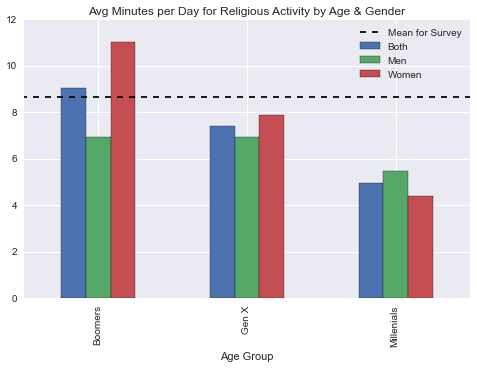

In [66]:
religion_table.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Religious Activity by Age & Gender", figsize=(8, 5))
plt.hlines(all_religion, xmin=-1, xmax=12, linestyle="dashed", label="Mean for Survey")
plt.legend()
plt.show()

We can see from this graph that women in the baby boomers age group spend more time on average engaging in religious or spiritual activity than any other age or gender group. The baby boomer generation also shows the greatest difference by gender, as women outstretched men by quite a bit. While both men and women in the millenials generation are pretty far below the mean for the survey, men in that age group spend more time than women in religious activity.

# Marital Status/Age Demographics

In [47]:
married_millenials = summary_cps[married_crit & adults_crit & millenials_crit_1]
single_millenials = summary_cps[single_crit & adults_crit & millenials_crit_1]
married_gen_x = summary_cps[married_crit & gen_x_crit_1 & gen_x_crit_2]
single_gen_x = summary_cps[single_crit & gen_x_crit_1 & gen_x_crit_2]
married_boomers = summary_cps[married_crit & boomers_crit_1 & boomers_crit_2]
single_boomers = summary_cps[single_crit & boomers_crit_1 & boomers_crit_2]

In [52]:
marr_mill_religion = average_minutes(married_millenials, "14")
sin_mill_religion = average_minutes(single_millenials, "14")
marr_genx_religion = average_minutes(married_gen_x, "14")
sin_genx_religion = average_minutes(single_gen_x, "14")
marr_boomers_religion = average_minutes(married_boomers, "14")
sin_boomers_religion = average_minutes(single_boomers, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [69]:
marr_mill_rel = {"Marital Status": "Married", "Age Group": "Millenials", "Religious Activity": marr_mill_religion}
sin_mill_rel = {"Marital Status": "Single", "Age Group": "Millenials", "Religious Activity": sin_mill_religion}
marr_x_rel = {"Marital Status": "Married", "Age Group": "Gen X", "Religious Activity": marr_genx_religion}
sin_x_rel = {"Marital Status": "Single", "Age Group": "Gen X", "Religious Activity": sin_genx_religion}
marr_boom_rel = {"Marital Status": "Married", "Age Group": "Boomers", "Religious Activity": marr_boomers_religion}
sin_boom_rel = {"Marital Status": "Single", "Age Group": "Boomers", "Religious Activity": sin_boomers_religion}
both_mill_rel = {"Marital Status": "Total", "Age Group": "Millenials", "Religious Activity": millenials_religion}
both_x_rel = {"Marital Status": "Total", "Age Group": "Gen X", "Religious Activity": gen_x_religion}
both_boom_rel = {"Marital Status": "Total", "Age Group": "Boomers", "Religious Activity": boomers_religion}
religion_agemarital = pd.DataFrame([marr_mill_rel, sin_mill_rel, marr_x_rel, sin_x_rel, marr_boom_rel, sin_boom_rel, both_mill_rel, both_x_rel, both_boom_rel])
religmarital_table = pd.pivot_table(religion_agemarital, values="Religious Activity", index="Age Group", columns="Marital Status")

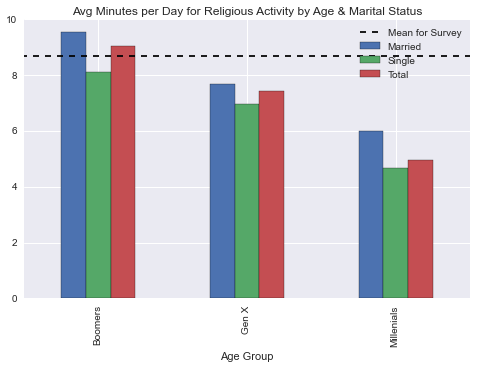

In [70]:
religmarital_table.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Religious Activity by Age & Marital Status", figsize=(8, 5))
plt.hlines(all_religion, xmin=-1, xmax=12, linestyle="dashed", label="Mean for Survey")
plt.legend()
plt.show()

For all three age groups, married people spend more time than single people engaging in religious and spiritual activity. The difference seems to be greatest among the millenials generation.

In [57]:
marr_child_religion = average_minutes(married_with_children, "14")
marr_nochild_religion = average_minutes(married_no_children, "14")
sing_child_religion = average_minutes(single_with_children, "14")
sing_nochild_religion = average_minutes(single_no_children, "14")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [61]:
marr_child_rel = {"Marital Status": "Married", "Children": "With Children", "Religious Activity": marr_child_religion}
marr_nochild_rel = {"Marital Status": "Married", "Children": "No Children", "Religious Activity": marr_nochild_religion}
sing_child_rel = {"Marital Status": "Single", "Children": "With Children", "Religious Activity": sing_child_religion}
sing_nochild_rel = {"Marital Status": "Single", "Children": "No Children", "Religious Activity": sing_nochild_religion}
religion_marrchild = pd.DataFrame([marr_child_rel, marr_nochild_rel, sing_child_rel, sing_nochild_rel])
religmarrchild_table = pd.pivot_table(religion_marrchild, values="Religious Activity", index="Marital Status", columns="Children")

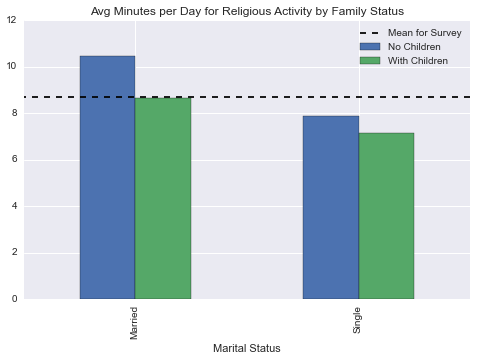

In [73]:
religmarrchild_table.plot(kind="bar", label="Minutes", title="Avg Minutes per Day for Religious Activity by Family Status", figsize=(8, 5))
plt.hlines(all_religion, xmin=-1, xmax=12, linestyle="dashed", label="Mean for Survey")
plt.legend()
plt.show()

Married people with no children spend more time in religious activity than married people with children or either single group.

In [77]:
religious_adults = activity_present(adults, "14", 60)

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [78]:
avg_reading = average_minutes(men, "120312")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [80]:
average_minutes(religious_adults, "120312")

/Users/abarringer/new_python/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


23.233290880934792